In [7]:
import sys
import rosbag
import time
import rospy
import os
import argparse
import math
import re
import h5py
import numpy as np
import ros_numpy
import matplotlib.pyplot as plt
from sensor_msgs.msg import Image, PointCloud2, PointField, JointState
from cv_bridge import CvBridge, CvBridgeError
from tqdm import tqdm, trange

## user define
- frame rate
- chunck length
- bags directory
- output file path/name
- topics need to transfer
- reference
    - https://support.hdfgroup.org/HDF5/doc/Advanced/Chunking/
    - http://docs.h5py.org/en/stable/high/dataset.html

In [8]:
frame_rate = 100  # Hz
chunck_len = 100  # number of frames in .hdf5 file
bags_dir = '/home/jacky/Videos/rosbag'
output_file_prefix = '/home/jacky/subt-analyze/05-ros-extraction-hdf5/'

topic_list = {
    #'/husky2/velodyne1/velodyne_points': 'lidar',
    #'/husky2/camera_left/color/image_raw': 'left_image',
    #'/husky2/camera_middle/color/image_raw': 'middle_image',
    #'/husky2/camera_right/color/image_raw': 'right_image',
    #'/husky2/camera_left/aligned_depth_to_color/image_raw': 'left_depth',
    #'/husky2/camera_middle/aligned_depth_to_color/image_raw': 'middle_depth',
    #'/husky2/camera_right/aligned_depth_to_color/image_raw': 'right_depth',
    '/wx200/joint_states': 'robot_arm',
}

#info for meta
vehicle = 'wx200'
place = 'ED-B1'
date_time = '07/21-19:58'

## user define 
msg to numpy array

ros_numpy : https://github.com/eric-wieser/ros_numpy

- image (width,height,channel)
- point cloud (xyz, number_of_points)

In [9]:
def msg_to_np(topic,msg):
    data = None
    if topic == '/husky2/velodyne1/velodyne_points':
        data_tmp = ros_numpy.point_cloud2.pointcloud2_to_xyz_array(
            msg)
        # swapaxis (3,points_number)
        data_tmp = np.swapaxes(data_tmp, 1, 0)
        data = []
        for i in range(data_tmp.shape[0]):
            data.append(np.array(data_tmp[i]))

    elif topic == '/husky2/camera_left/color/image_raw':
        data = ros_numpy.image.image_to_numpy(msg)

    elif topic == '/husky2/camera_middle/color/image_raw':
        data = ros_numpy.image.image_to_numpy(msg)

    elif topic == '/husky2/camera_right/color/image_raw':
        data = ros_numpy.image.image_to_numpy(msg)

    elif topic == '/husky2/camera_left/aligned_depth_to_color/image_raw':
        data = ros_numpy.image.image_to_numpy(msg)

    elif topic == '/husky2/camera_middle/aligned_depth_to_color/image_raw':
        data = ros_numpy.image.image_to_numpy(msg)

    elif topic == '/husky2/camera_right/aligned_depth_to_color/image_raw':
        data = ros_numpy.image.image_to_numpy(msg)
    elif topic == '/wx200/joint_states':
        cur_pos_arr = np.zeros( (8, 1) )
        data = np.zeros( (8, 1) )
        for i in range(0, len(msg.position)):
            cur_pos_arr[i, 0] = msg.position[i]
            print(cur_pos_arr[i, 0])
        data = np.append(data, cur_pos_arr, axis = 1)
    
    return data

## add dataset
    lidar has unknown length data
    need to use special_dtype

In [10]:
def add_dataset(f, key, data, chunck_len):
    if key == 'lidar':
        dt = h5py.special_dtype(vlen=np.dtype('float32'))
        shape = (chunck_len, 3)
        max_shape = (None, 3)
    else:
        dt = data.dtype
        shape = (chunck_len,) + data.shape
        max_shape = (None,) + data.shape

    return f.create_dataset(key, shape=shape,
                        maxshape=max_shape, dtype=dt, chunks=True)

In [11]:
def add_meta(f):
    meta = f.create_group('metadata')
    meta.attrs['vehicle'] = vehicle
    meta.attrs['place'] = 'ED-B1'
    meta.attrs['date_time'] = date_time
    meta.attrs['frame_rate'] = frame_rate
    meta.attrs['trajectory_length'] = chunck_len
    for i,(key,value) in enumerate(topic_list.items()):
        meta.attrs[value] = key

## start process bags
rosbag : http://wiki.ros.org/rosbag/Code%20API

In [12]:
bags = os.listdir(bags_dir)[::-1]
bags.sort()
b = None
frame = 0
step = 0
epi = 0
tp = None
dropped_frame = 0
mark, report = {}, {}
for value in topic_list.values():
    mark.update({value:0})
    report.update({value:[]})

f = h5py.File(output_file_prefix+"_%03d.hdf5"%epi, 'w')
add_meta(f)

pbar = tqdm(bags)

for bag_name in pbar:
    print(bag_name)
    b = rosbag.Bag(bags_dir+'/'+bag_name)
    for topic, msg, t in b.read_messages(topic_list.keys()):
        if tp is None:
            tp = t
        else:
            if not topic_list[topic] in f.keys():
                # create dataset
                data = msg_to_np(topic,msg)
                dset = add_dataset(f,topic_list[topic],data,chunck_len)

            f[topic_list[topic]][step] = msg_to_np(topic,msg)
            mark[topic_list[topic]] = 1
            
            # cut frame ------------------------------------------------------------------
            if (t-tp).to_sec() > 1./frame_rate:
                tp = t
                drop = False
                frame += 1
                # if there is one msg missing in this frame
                # drop this frame
                for i, (key, value) in enumerate(mark.items()):
                    report[key].append(value)
                    if value is 0:
                        drop = True
                        dropped_frame += 1
                    mark[key] = 0

                pbar.set_description("frame:%d, drop:%d , bag:%s"%(frame,dropped_frame,bag_name))
                if not drop:
                    step += 1
                    if step == chunck_len:
                        step = 0
                        epi += 1
                        f.close()
                        del f
                        f = h5py.File(output_file_prefix+"_%03d.hdf5"%epi, 'w')
                        add_meta(f)
                    # end if
               # end if
            # end if
        # end if
    # end for
    b.close()
    del b
f.close()
print 'finish'

frame:17, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:00<?, ?it/s]

wx200.bag
-0.06289321184158325
-1.9205440282821655
-1.656699299812317
-0.6089903712272644
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.9205440282821655
-1.656699299812317
-0.6089903712272644
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.9205440282821655
-1.6551653146743774
-0.607456386089325
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.9205440282821655
-1.6551653146743774
-0.6089903712272644
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.9205440282821655
-1.6551653146743774
-0.6089903712272644
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.9205440282821655
-1.6551653146743774
-0.6089903712272644
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.062893211841

frame:65, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:00<?, ?it/s]

-0.6089903712272644
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.9205440282821655
-1.6551653146743774
-0.6089903712272644
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.9205440282821655
-1.6551653146743774
-0.607456386089325
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.9205440282821655
-1.6551653146743774
-0.6089903712272644
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.9205440282821655
-1.656699299812317
-0.6089903712272644
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.9205440282821655
-1.6551653146743774
-0.6089903712272644
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.9205440282821655
-1.6551653146743774
-0.6089903712272644
-0.0

frame:115, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:00<?, ?it/s]

-0.06289321184158325
-1.9205440282821655
-1.656699299812317
-0.6059224009513855
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.9205440282821655
-1.6551653146743774
-0.6059224009513855
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.9205440282821655
-1.6551653146743774
-0.6059224009513855
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.9205440282821655
-1.656699299812317
-0.6043884754180908
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.9205440282821655
-1.6551653146743774
-0.6059224009513855
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.9205440282821655
-1.6551653146743774
-0.6059224009513855
-0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.

frame:161, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:00<?, ?it/s]

-0.06289321184158325
-1.8024275302886963
-1.6198837757110596
-0.4187767803668976
-0.02454369328916073
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.7993595600128174
-1.6168158054351807
-0.4187767803668976
-0.02454369328916073
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.794757604598999
-1.6137478351593018
-0.41724279522895813
-0.02454369328916073
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.7916896343231201
-1.6106798648834229
-0.41724279522895813
-0.02454369328916073
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.7886216640472412
-1.607611894607544
-0.41724279522895813
-0.02454369328916073
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.7840197086334229
-1.6030099391937256
-0.41724279522895813
-0.02454369328916073
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.78

frame:211, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:01<?, ?it/s]

-0.06289321184158325
-1.480291485786438
-1.323825478553772
-0.41724279522895813
-0.010737866163253784
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.4726215600967407
-1.3176895380020142
-0.4187767803668976
-0.00920388475060463
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.4649516344070435
-1.3115535974502563
-0.41724279522895813
-0.00920388475060463
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.4572818279266357
-1.3054176568984985
-0.41724279522895813
-0.0076699042692780495
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.4496119022369385
-1.2992817163467407
-0.41724279522895813
-0.0076699042692780495
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.4419419765472412
-1.2931458950042725
-0.41724279522895813
-0.006135923322290182
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0628932118415832

frame:262, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:01<?, ?it/s]

-0.06289321184158325
-1.06918466091156
-1.0814565420150757
-0.4325825870037079
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.06918466091156
-1.0829904079437256
-0.43718454241752625
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.06918466091156
-1.0829904079437256
-0.44025251269340515
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.06918466091156
-1.0814565420150757
-0.44332045316696167
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.06918466091156
-1.0829904079437256
-0.44792240858078003
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.06918466091156
-1.0814565420150757
-0.452524334192276
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.0676506757736206
-1

frame:307, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:01<?, ?it/s]

-0.06289321184158325
-1.055378794670105
-0.8084079027175903
-1.1060001850128174
0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.0538448095321655
-0.803805947303772
-1.1106021404266357
0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.0538448095321655
-0.8007379770278931
-1.1136701107025146
0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.0538448095321655
-0.7992039918899536
-1.115204095840454
0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.0538448095321655
-0.7961360216140747
-1.118272066116333
0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.0538448095321655
-0.79460209608078
-1.121340036392212
0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.05384480953

frame:358, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:01<?, ?it/s]

-0.06289321184158325
-1.04157292842865
-0.6918253302574158
-1.382116675376892
0.029145635664463043
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.0400390625
-0.6902913451194763
-1.385184645652771
0.029145635664463043
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.0400390625
-0.6872234344482422
-1.38825261592865
0.029145635664463043
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.0385050773620605
-0.6841554641723633
-1.3913205862045288
0.029145635664463043
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.0385050773620605
-0.6826214790344238
-1.3943885564804077
0.029145635664463043
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.0385050773620605
-0.6795535087585449
-1.3974565267562866
0.029145635664463043
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.036971092224121
-0.678

frame:404, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:01<?, ?it/s]

-0.06289321184158325
-1.026233196258545
-0.7746603488922119
-0.9464661478996277
0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.026233196258545
-0.7761942744255066
-0.9387962818145752
0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.026233196258545
-0.780796229839325
-0.9311263561248779
0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.026233196258545
-0.7838642001152039
-0.9249904155731201
0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.026233196258545
-0.7869321703910828
-0.9173205494880676
0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.0246992111206055
-0.7884661555290222
-0.9127185940742493
0.030679617077112198
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.0246992111

frame:452, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:02<?, ?it/s]

-0.06289321184158325
-1.087592363357544
-0.8513593673706055
-0.8099418878555298
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.0860583782196045
-0.8513593673706055
-0.8099418878555298
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.087592363357544
-0.8513593673706055
-0.8099418878555298
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.0860583782196045
-0.8513593673706055
-0.8099418878555298
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.087592363357544
-0.8513593673706055
-0.8099418878555298
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.087592363357544
-0.8513593673706055
-0.8099418878555298
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.06289321184158325
-1.08759236335754

frame:503, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:02<?, ?it/s]

-0.0475534051656723
-1.0768545866012573
-0.8559613227844238
-0.7915341258049011
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.04448544234037399
-1.0768545866012573
-0.8544273376464844
-0.7900001406669617
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.04141748324036598
-1.0768545866012573
-0.8528933525085449
-0.7900001406669617
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.03834952041506767
-1.0768545866012573
-0.8528933525085449
-0.7900001406669617
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.03528155758976936
-1.0753206014633179
-0.8513593673706055
-0.7884661555290222
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.030679617077112198
-1.0768545866012573
-0.849825382232666
-0.7869321703910828
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.02761165425181389
-1.07685458660

frame:550, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:02<?, ?it/s]

0.6948933005332947
-1.0921943187713623
-0.7347767949104309
-0.5737088322639465
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.6948933005332947
-1.0921943187713623
-0.7317088842391968
-0.5691068768501282
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.6948933005332947
-1.0921943187713623
-0.7286409139633179
-0.5645049214363098
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.6948933005332947
-1.0921943187713623
-0.725572943687439
-0.5629709362983704
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.6948933005332947
-1.0921943187713623
-0.7225049734115601
-0.5599030256271362
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.6948933005332947
-1.0921943187713623
-0.7179030179977417
-0.5568350553512573
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.6948933005332947
-1.0921943187713623
-0.71483

frame:600, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:02<?, ?it/s]

0.644271969795227
-0.8406214714050293
-0.5844466686248779
-0.14419420063495636
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.6335340738296509
-0.8360195755958557
-0.5859806537628174
-0.1426602154970169
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.6227962374687195
-0.8314176201820374
-0.5890486240386963
-0.14419420063495636
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.6135923266410828
-0.826815664768219
-0.5905826091766357
-0.1426602154970169
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.6013205051422119
-0.8222137093544006
-0.5921165943145752
-0.14419420063495636
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.5890486240386963
-0.8191457390785217
-0.5951845645904541
-0.14419420063495636
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.5767768025398254
-0.8145438432693481
-0.59

frame:647, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:02<?, ?it/s]


-0.03641690613955677
-0.13345633447170258
-0.8191457390785217
-0.7424467206001282
-0.4632622003555298
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.13499031960964203
-0.8298836350440979
-0.7455146908760071
-0.4693981409072876
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.1365242898464203
-0.8421554565429688
-0.748582661151886
-0.475534051656723
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.1365242898464203
-0.8528933525085449
-0.7531846165657043
-0.4832039475440979
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.13805827498435974
-0.8651651740074158
-0.7562525272369385
-0.49087387323379517
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.1395922601222992
-0.8774370551109314
-0.7593204975128174
-0.49854376912117004
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.141126230359

frame:697, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:03<?, ?it/s]

-0.1457281857728958
-1.3499031066894531
-0.8866409063339233
-0.7992039918899536
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.14879614114761353
-1.3468351364135742
-0.8866409063339233
-0.7976700067520142
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.1457281857728958
-1.3437671661376953
-0.8851069211959839
-0.7961360216140747
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.1457281857728958
-1.339165210723877
-0.8851069211959839
-0.79460209608078
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.1457281857728958
-1.3345633745193481
-0.8835729360580444
-0.7930681109428406
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.14879614114761353
-1.3299614191055298
-0.882038950920105
-0.7915341258049011
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.1457281857728958
-1.3253594636917114

frame:745, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:03<?, ?it/s]

-0.058291271328926086
-0.6412039995193481
-0.5046796798706055
-0.34514567255973816
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.05368933081626892
-0.630466103553772
-0.49547579884529114
-0.3405437469482422
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.04908738657832146
-0.6197282671928406
-0.4862719178199768
-0.3374757766723633
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.04601942375302315
-0.6089903712272644
-0.4770680367946625
-0.3344078063964844
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.04141748324036598
-0.5967185497283936
-0.4693981409072876
-0.3328738510608673
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.04141748324036598
-0.5967185497283936
-0.4693981409072876
-0.3328738510608673
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.03681553900241852
-0.5875146

frame:795, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:03<?, ?it/s]

0.48780590295791626
-0.6488738656044006
-0.6826214790344238
-0.32520392537117004
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.4939418137073517
-0.6580777764320374
-0.6872234344482422
-0.3267379105091095
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.5016117095947266
-0.6688156127929688
-0.6918253302574158
-0.32827189564704895
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.5077476501464844
-0.6780195236206055
-0.6964272856712341
-0.3298058807849884
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.5154175758361816
-0.6872234344482422
-0.7010292410850525
-0.33133986592292786
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.5215534567832947
-0.6964272856712341
-0.7056311964988708
-0.33594179153442383
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.5292233824729919
-0.7056311964988708


frame:840, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:03<?, ?it/s]

0.3405437469482422
-1.2057089805603027
-0.7163690328598022
-0.7286409139633179
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.33594179153442383
-1.2133787870407104
-0.7163690328598022
-0.7317088842391968
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.33133986592292786
-1.2195147275924683
-0.7179030179977417
-0.7347767949104309
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.3267379105091095
-1.2271846532821655
-0.7179030179977417
-0.7393787503242493
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.3221359848976135
-1.2333205938339233
-0.7179030179977417
-0.7409127354621887
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.31753402948379517
-1.2409905195236206
-0.7194370031356812
-0.7439807057380676
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.3129321038722992
-1.2471264600753784
-0

frame:885, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:03<?, ?it/s]

0.052155349403619766
-1.6689711809158325
-0.8574953079223633
-0.8406214714050293
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0475534051656723
-1.667437195777893
-0.8620972037315369
-0.8436894416809082
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.04601942375302315
-1.6659032106399536
-0.8682331442832947
-0.8436894416809082
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.04448544234037399
-1.6659032106399536
-0.8743690848350525
-0.8467574119567871
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.04295146465301514
-1.6628352403640747
-0.8789710402488708
-0.8482913970947266
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.04141748324036598
-1.6597672700881958
-0.8851069211959839
-0.8482913970947266
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.03988350182771683
-1.6551653146743774
-

frame:926, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:04<?, ?it/s]

0.03681553900241852
-0.8682331442832947
-0.8805050253868103
-0.44025251269340515
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.03528155758976936
-0.8528933525085449
-0.8743690848350525
-0.43104860186576843
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.03681553900241852
-0.8360195755958557
-0.8697671294212341
-0.42031073570251465
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.03681553900241852
-0.8206797242164612
-0.8651651740074158
-0.4111068546772003
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.03528155758976936
-0.8053399324417114
-0.8605632185935974
-0.40036898851394653
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.03681553900241852
-0.7900001406669617
-0.8544273376464844
-0.38963112235069275
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.03681553900241852
-0.77466034889

frame:970, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:04<?, ?it/s]

0.29452431201934814
-0.28378644585609436
-0.5706408619880676
-0.25617480278015137
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.30526217818260193
-0.2853204309940338
-0.5721748471260071
-0.2546408176422119
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.31446605920791626
-0.28685441613197327
-0.5737088322639465
-0.2546408176422119
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.32520392537117004
-0.2899223864078522
-0.575242817401886
-0.2546408176422119
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.3328738510608673
-0.2914563715457916
-0.5783107876777649
-0.2546408176422119
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.34207773208618164
-0.29452431201934814
-0.5813787579536438
-0.25617480278015137
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.3528155982494354
-0.297592282295

frame:1015, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:04<?, ?it/s]

0.475534051656723
-0.8191457390785217
-0.8283496499061584
-0.6166602969169617
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.475534051656723
-0.8314176201820374
-0.8283496499061584
-0.62126225233078
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.475534051656723
-0.8436894416809082
-0.8283496499061584
-0.6273981332778931
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.475534051656723
-0.8559613227844238
-0.826815664768219
-0.6335340738296509
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.475534051656723
-0.8682331442832947
-0.826815664768219
-0.6427379846572876
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.475534051656723
-0.8805050253868103
-0.8252816796302795
-0.647339940071106
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.475534051656723
-0.8912428617477417
-0.8252816796302

frame:1060, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:04<?, ?it/s]

0.06902913749217987
-1.3406991958618164
-0.8176117539405823
-0.8528933525085449
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.05522330850362778
-1.3406991958618164
-0.8160778284072876
-0.8513593673706055
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.03681553900241852
-1.3406991958618164
-0.8160778284072876
-0.8513593673706055
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.02454369328916073
-1.3422331809997559
-0.8160778284072876
-0.849825382232666
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0076699042692780495
-1.3422331809997559
-0.8160778284072876
-0.849825382232666
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.004601942375302315
-1.3422331809997559
-0.8160778284072876
-0.8482913970947266
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.019941750913858414
-1.342233180999

frame:1107, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:04<?, ?it/s]

-0.5783107876777649
-1.303883671760559
-0.7378447651863098
-0.6688156127929688
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.5783107876777649
-1.303883671760559
-0.7332428097724915
-0.6688156127929688
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.5783107876777649
-1.3008157014846802
-0.7271069288253784
-0.6688156127929688
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.5783107876777649
-1.2992817163467407
-0.7209709882736206
-0.6672816872596741
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.5783107876777649
-1.2977477312088013
-0.7148350477218628
-0.6657477021217346
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.5783107876777649
-1.294679880142212
-0.7086991667747498
-0.6657477021217346
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.5783107876777649
-1.29161190986633

frame:1154, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:05<?, ?it/s]

-0.0015339808305725455
-0.630466103553772
-0.07056311517953873
-0.630466103553772
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.010737866163253784
-0.6243302226066589
-0.06749515980482101
-0.630466103553772
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.02454369328916073
-0.6181942820549011
-0.06596117466688156
-0.630466103553772
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.03528155758976936
-0.6135923266410828
-0.0644271969795227
-0.630466103553772
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0475534051656723
-0.607456386089325
-0.0644271969795227
-0.630466103553772
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.061359234154224396
-0.6028544902801514
-0.06289321184158325
-0.630466103553772
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.07363107800483704
-0.59671854972

frame:1191, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:05<?, ?it/s]

0.5491651296615601
-0.653475821018219
-0.4555923044681549
-0.6626797318458557
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.5491651296615601
-0.6565437912940979
-0.4663301706314087
-0.6626797318458557
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.5506991147994995
-0.6626797318458557
-0.4770680367946625
-0.6626797318458557
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.5491651296615601
-0.6672816872596741
-0.48780590295791626
-0.6626797318458557
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.5491651296615601
-0.6734175682067871
-0.49854376912117004
-0.6611457467079163
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.5491651296615601
-0.6780195236206055
-0.5077476501464844
-0.6626797318458557
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.5491651296615601
-0.6841554641723633


frame:1234, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:05<?, ?it/s]

0.3298058807849884
-1.164291501045227
-0.7577865123748779
-0.7900001406669617
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.3206019997596741
-1.1750292778015137
-0.7577865123748779
-0.7930681109428406
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.31139811873435974
-1.1857671737670898
-0.7593204975128174
-0.7976700067520142
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.3021942377090454
-1.1949710845947266
-0.7608544826507568
-0.8022719621658325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.29452431201934814
-1.2057089805603027
-0.7608544826507568
-0.8068739175796509
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.28685441613197327
-1.21491277217865
-0.7623884677886963
-0.8130098581314087
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.27765053510665894
-1.2241166830062866


frame:1285, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:05<?, ?it/s]

-0.02761165425181389
-1.5385828018188477
-0.6120583415031433
-1.072252631187439
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.030679617077112198
-1.5370488166809082
-0.607456386089325
-1.0768545866012573
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.03374757990241051
-1.5370488166809082
-0.6043884754180908
-1.0814565420150757
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.03528155758976936
-1.5370488166809082
-0.6028544902801514
-1.0860583782196045
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.03834952041506767
-1.5370488166809082
-0.6013205051422119
-1.0906603336334229
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.04141748324036598
-1.5370488166809082
-0.5997865200042725
-1.0967962741851807
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.04448544234037399
-1.53551483

frame:1332, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:05<?, ?it/s]

-0.31753402948379517
-1.4081944227218628
-0.849825382232666
-0.921922504901886
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.3160000443458557
-1.4051264524459839
-0.8528933525085449
-0.9173205494880676
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.3160000443458557
-1.4005244970321655
-0.8528933525085449
-0.9127185940742493
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.31446605920791626
-1.3959225416183472
-0.8559613227844238
-0.905048668384552
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.3160000443458557
-1.3913205862045288
-0.8559613227844238
-0.9004467725753784
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.31446605920791626
-1.385184645652771
-0.8574953079223633
-0.8958448171615601
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.31446605920791626
-1.3821166753768

frame:1380, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:06<?, ?it/s]

0.1564660519361496
-0.826815664768219
-0.5629709362983704
-0.6427379846572876
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.16566993296146393
-0.8191457390785217
-0.5506991147994995
-0.6427379846572876
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.17487381398677826
-0.8114758729934692
-0.5399612784385681
-0.6412039995193481
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.18254372477531433
-0.803805947303772
-0.5292233824729919
-0.6412039995193481
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.1902136206626892
-0.7976700067520142
-0.5184855461120605
-0.6427379846572876
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.19788353145122528
-0.7900001406669617
-0.5062136650085449
-0.6427379846572876
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.2040194571018219
-0.7823302149772644

frame:1430, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:06<?, ?it/s]

0.22702915966510773
-0.5353593230247498
0.2316311001777649
-0.6749515533447266
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.22702915966510773
-0.5368933081626892
0.22549518942832947
-0.6795535087585449
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.22702915966510773
-0.5384272933006287
0.2178252786397934
-0.6826214790344238
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.22702915966510773
-0.5414952039718628
0.20862139761447906
-0.6841554641723633
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.22702915966510773
-0.5445631742477417
0.19941750168800354
-0.6841554641723633
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.22702915966510773
-0.5476311445236206
0.1902136206626892
-0.6856894493103027
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.22702915966510773
-0.550699114799499

frame:1476, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:06<?, ?it/s]

0.12732040882110596
-1.1888351440429688
-0.6688156127929688
-0.6749515533447266
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.12425244599580765
-1.2026410102844238
-0.6749515533447266
-0.6826214790344238
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.12425244599580765
-1.21491277217865
-0.6810874938964844
-0.6902913451194763
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.12425244599580765
-1.228718638420105
-0.6887574195861816
-0.6979612708091736
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.12425244599580765
-1.24252450466156
-0.6948933005332947
-0.7056311964988708
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.12425244599580765
-1.2547962665557861
-0.7010292410850525
-0.7148350477218628
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.12425244599580765
-1.2686021327972412
-

frame:1526, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:06<?, ?it/s]

0.10584467649459839
-1.512505054473877
-0.9924855828285217
-0.7317088842391968
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.10584467649459839
-1.509437084197998
-0.9940195679664612
-0.7240389585494995
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.10584467649459839
-1.5048352479934692
-0.9955535531044006
-0.7179030179977417
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.10584467649459839
-1.5002332925796509
-0.9970875382423401
-0.7102331519126892
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.10584467649459839
-1.4956313371658325
-0.9986215233802795
-0.7040972113609314
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.10584467649459839
-1.4910293817520142
-1.0001554489135742
-0.6964272856712341
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.10584467649459839
-1.4864274263381958


frame:1575, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:06<?, ?it/s]

0.03681553900241852
-0.780796229839325
-0.9035146832466125
-0.6089903712272644
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.03681553900241852
-0.771592378616333
-0.9004467725753784
-0.6181942820549011
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.03681553900241852
-0.7608544826507568
-0.898912787437439
-0.6258642077445984
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.03681553900241852
-0.7516506314277649
-0.8973788022994995
-0.6350680589675903
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.03681553900241852
-0.7439807057380676
-0.8943108320236206
-0.644271969795227
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.03681553900241852
-0.7363107800483704
-0.8927768468856812
-0.6519418358802795
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.03681553900241852
-0.730174899101257

frame:1623, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:07<?, ?it/s]


0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.22549518942832947
-1.509437084197998
-0.921922504901886
-1.0108933448791504
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.22549518942832947
-1.5247769355773926
-0.9234564304351807
-1.0139613151550293
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.22702915966510773
-1.5416507720947266
-0.9249904155731201
-1.0170292854309082
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.22702915966510773
-1.558524489402771
-0.9265244007110596
-1.023165225982666
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.22549518942832947
-1.5769323110580444
-0.928058385848999
-1.0277671813964844
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.22549518942832947
-1.5922720432281494
-0.9311263561248779
-1.0323691368103027
0.02761165425181389
1.18883514404

frame:1676, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:07<?, ?it/s]

-0.20555342733860016
-1.8361750841140747
-1.1274758577346802
-1.026233196258545
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.20248547196388245
-1.8361750841140747
-1.1290098428726196
-1.023165225982666
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.19634954631328583
-1.8346410989761353
-1.130543828010559
-1.020097255706787
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.1902136206626892
-1.8331071138381958
-1.1320778131484985
-1.0154953002929688
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.18254372477531433
-1.8331071138381958
-1.133611798286438
-1.0108933448791504
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.17487381398677826
-1.8315731287002563
-1.1351457834243774
-1.006291389465332
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.1672039031982422
-1.83003914356231

frame:1713, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:07<?, ?it/s]

0.0951068103313446
-1.572330355644226
-1.2225826978683472
-0.7317088842391968
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.09664079546928406
-1.5661944150924683
-1.2271846532821655
-0.7317088842391968
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.09664079546928406
-1.5600584745407104
-1.2302526235580444
-0.7317088842391968
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0951068103313446
-1.555456519126892
-1.2348545789718628
-0.7317088842391968
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0951068103313446
-1.5493206977844238
-1.2394565343856812
-0.7317088842391968
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0951068103313446
-1.543184757232666
-1.2440584897994995
-0.7332428097724915
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0951068103313446
-1.5385828018188477
-1

frame:1757, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:07<?, ?it/s]

-1.2977477312088013
-1.1857671737670898
-0.7301748991012573
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0920388475060463
-1.2931458950042725
-1.1780972480773926
-0.7317088842391968
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0920388475060463
-1.288543939590454
-1.1719613075256348
-0.7317088842391968
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0920388475060463
-1.2854759693145752
-1.164291501045227
-0.7332428097724915
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0920388475060463
-1.2793400287628174
-1.1550875902175903
-0.7347767949104309
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0920388475060463
-1.274738073348999
-1.1458836793899536
-0.7393787503242493
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0920388475060463
-1.2701361179351807
-1.1382137537002563
-0.

frame:1803, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:07<?, ?it/s]

0.08743690699338913
-0.7133010625839233
-0.4157088100910187
-0.7194370031356812
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.08743690699338913
-0.7086991667747498
-0.4080389142036438
-0.7194370031356812
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.08743690699338913
-0.7040972113609314
-0.401902973651886
-0.7209709882736206
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.08743690699338913
-0.699495255947113
-0.39576706290245056
-0.7225049734115601
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.08743690699338913
-0.6964272856712341
-0.38963112235069275
-0.7240389585494995
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.08743690699338913
-0.6948933005332947
-0.3850291967391968
-0.7271069288253784
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.08743690699338913
-0.69335931539

frame:1843, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:08<?, ?it/s]


-0.03641690613955677
0.0076699042692780495
-1.3775148391723633
-0.8559613227844238
-0.9357283115386963
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0076699042692780495
-1.3897866010665894
-0.8651651740074158
-0.9372622966766357
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0076699042692780495
-1.4035924673080444
-0.872835099697113
-0.9387962818145752
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0076699042692780495
-1.4143303632736206
-0.8835729360580444
-0.9387962818145752
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0076699042692780495
-1.4250681400299072
-0.8927768468856812
-0.9387962818145752
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0076699042692780495
-1.4373400211334229
-0.9019807577133179
-0.9403302669525146
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0

frame:1889, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:08<?, ?it/s]

0.0076699042692780495
-1.7103886604309082
-1.1489516496658325
-0.9464661478996277
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0076699042692780495
-1.7119226455688477
-1.150485634803772
-0.9464661478996277
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0076699042692780495
-1.7149906158447266
-1.1535536050796509
-0.9464661478996277
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0076699042692780495
-1.716524600982666
-1.1566215753555298
-0.9464661478996277
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0076699042692780495
-1.7180585861206055
-1.1581555604934692
-0.9464661478996277
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.0076699042692780495
-1.7195924520492554
-1.1596895456314087
-0.9464661478996277
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
0.006135923322290182
-1.7

frame:1936, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:08<?, ?it/s]

-0.0076699042692780495
-1.8453789949417114
-1.2655341625213623
-0.954136073589325
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.8484468460083008
-1.2655341625213623
-0.9526020884513855
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.8484468460083008
-1.2686021327972412
-0.954136073589325
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.8499808311462402
-1.2701361179351807
-0.9526020884513855
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.8515148162841797
-1.2732040882110596
-0.954136073589325
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.8530488014221191
-1.274738073348999
-0.954136073589325
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.8

frame:1987, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:08<?, ?it/s]

-0.0076699042692780495
-1.9128741025924683
-1.385184645652771
-0.9480001330375671
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9128741025924683
-1.38825261592865
-0.9464661478996277
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9128741025924683
-1.3913205862045288
-0.9433982372283936
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9128741025924683
-1.3943885564804077
-0.9403302669525146
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9128741025924683
-1.3974565267562866
-0.9372622966766357
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9128741025924683
-1.4005244970321655
-0.9357283115386963
0.02761165425181389
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495


frame:2032, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:08<?, ?it/s]

-0.0076699042692780495
-1.9144080877304077
-1.636757493019104
-0.40036898851394653
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9144080877304077
-1.6413594484329224
-0.40036898851394653
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9144080877304077
-1.6459614038467407
-0.40036898851394653
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9144080877304077
-1.650563359260559
-0.3988350033760071
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9144080877304077
-1.653631329536438
-0.3988350033760071
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9144080877304077
-1.656699299812317
-0.3988350033760071
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.00766990426927

frame:2078, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:09<?, ?it/s]

-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.630466103553772
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.6520973443984985
-0.630466103553772
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.630466103553772
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.630466103553772
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.6520973443984985
-0.630466103553772
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.630466103553772
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.

frame:2117, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:09<?, ?it/s]

-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495

frame:2155, drop:0 , bag:wx200.bag:   0%|          | 0/1 [00:09<?, ?it/s]


-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-

frame:2182, drop:0 , bag:wx200.bag: 100%|██████████| 1/1 [00:09<00:00,  9.75s/it]

-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495
-1.9159420728683472
-1.653631329536438
-0.6289321184158325
0.026077674701809883
1.1888351440429688
0.03641690613955677
-0.03641690613955677
-0.0076699042692780495

## status report
    show the dropped frame numbers

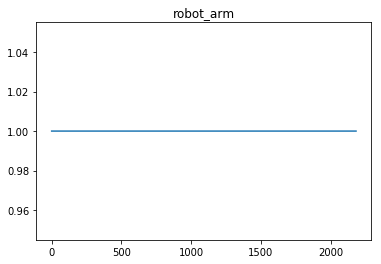

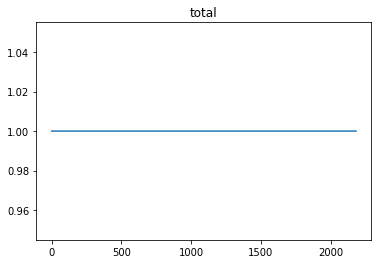

In [13]:
stat = []
for i, (key, value) in enumerate(report.items()):
    stat.append(value)
    plt.title(key)
    plt.plot(value)
    plt.show()
total = np.sum(stat,axis=0)
plt.title('total')
plt.plot(total)
plt.show()